In [10]:
# import required packages

import os
os.chdir("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.model_summary import summarize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from Utils.SingletonModelLoader import SingletonModelLoader
from Utils.TextProcessing import encode_text
from Utils.Predictions import predict_emotion_with_probs, compute_model_predictions
from Model.EmoClassifier import TextClassifierModule
from Common.Emotions import FINE_EMOTIONS, BROAD_EMOTIONS
from Data.Preprocessing import prepare_data
import json

# Setup hot realoading of modules when files in working dir change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
combined_data_path = "./datasets/combined_data.csv"

In [13]:
data_module,classes = prepare_data(data_path=combined_data_path,
                                label_name="fineEmo",
                                dataset_names=["Empathetic Dialogues"], 
                                split_train_val_test=[0.8,0.1,0.1], 
                                batch_size=32, 
                                RANDOM_SEED=5)

Training data shape:  (19671, 4) 
Validation data shape:  (2459, 4) 
Test data shape:  (2459, 4)


In [9]:
# Load models

fine_emotion_model = SingletonModelLoader.get_model_instance(
  'fine_classifier',
  './model_checkpoints/emotion-recognizer-fine.ckpt',
  TextClassifierModule)

broad_emotion_model = SingletonModelLoader.get_model_instance(
  'broad_classifier',
  './model_checkpoints/emotion-recognizer-broad.ckpt',
  TextClassifierModule)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.

In [11]:
text = input("Input text to get its emotion \n")
emotion, class_probabilities = predict_emotion_with_probs(fine_emotion_model, FINE_EMOTIONS, text)

print(emotion, "\n")
print(json.dumps(class_probabilities, indent=1))

Input text to get its emotion 
I wish this would have gone better.


Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


disappointment 

{
 "anger": "1.74%",
 "annoyance": "1.77%",
 "anticipating": "1.43%",
 "apprehensive": "2.78%",
 "ashamed": "2.65%",
 "caring": "1.19%",
 "confident": "0.58%",
 "content": "0.70%",
 "devastated": "4.43%",
 "disappointment": "30.57%",
 "disgusted": "2.61%",
 "embarrassment": "0.36%",
 "excitement": "1.12%",
 "faithful": "1.31%",
 "fear": "2.11%",
 "furious": "0.85%",
 "gratitude": "3.69%",
 "guilty": "3.34%",
 "hopeful": "2.86%",
 "impressed": "0.95%",
 "jealous": "1.77%",
 "joy": "0.98%",
 "lonely": "4.83%",
 "nostalgic": "0.69%",
 "prepared": "1.57%",
 "pride": "1.22%",
 "sadness": "12.06%",
 "sentimental": "2.26%",
 "surprise": "0.96%",
 "terrified": "1.52%",
 "trusting": "1.79%",
 "worry": "3.31%"
}


In [14]:
data_module.setup()
yHat, y = compute_model_predictions(fine_emotion_model, data_module.test_dataloader())

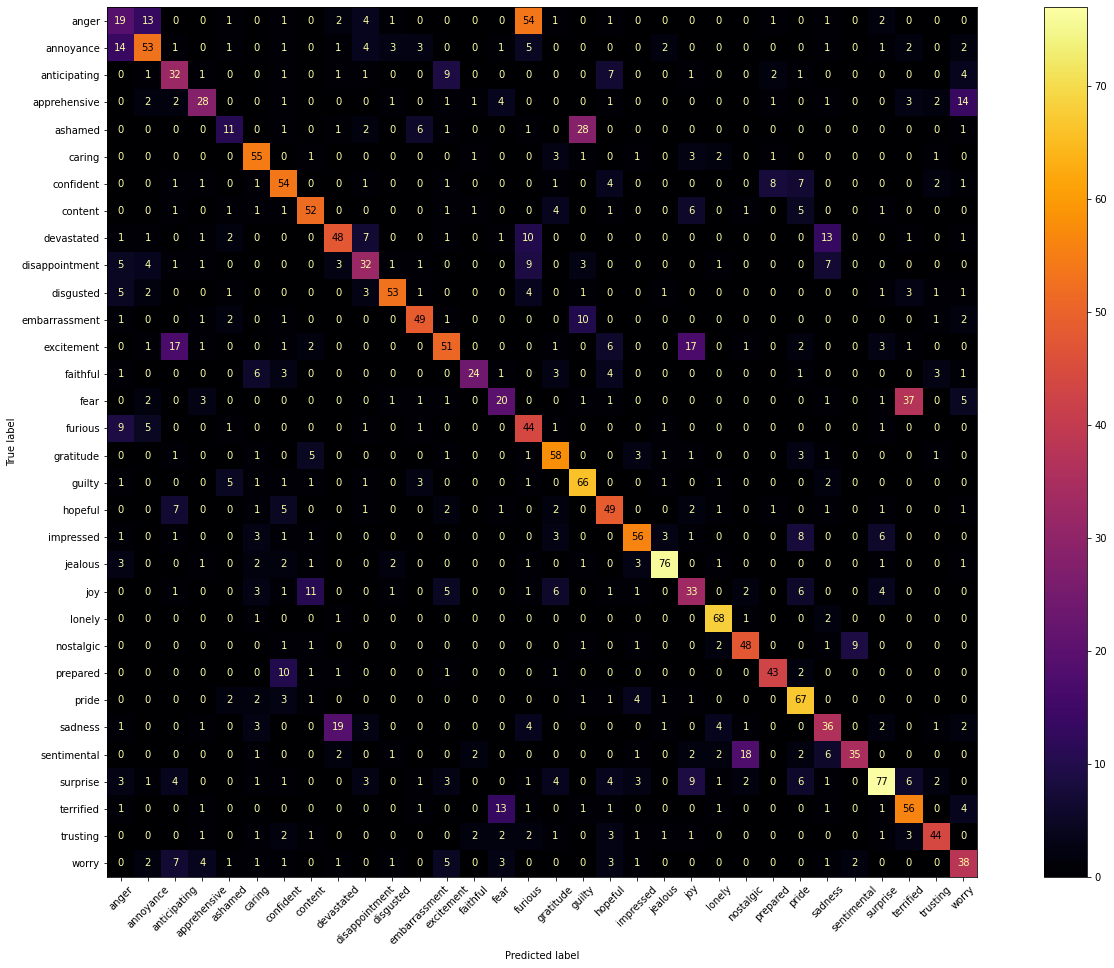

In [22]:
labs = FINE_EMOTIONS.tolist()

yList = y.tolist()
yHatList = yHat.tolist()
truth = list(map(lambda x: labs[x], yList))
preds = list(map(lambda x: labs[x], yHatList))

fig, ax = plt.subplots(figsize=(24, 16))
ConfusionMatrixDisplay.from_predictions(truth, preds, labels=labs, xticks_rotation=45, cmap="inferno", ax=ax)
plt.show()

In [16]:
f1_score(truth, preds, average="micro")

0.5998373322488817

In [17]:
f1_list = f1_score(yList, yHatList, average=None)
f1_scores = dict()
for i, v in enumerate(f1_list):
  f1_scores[labs[i]] = v

print(json.dumps(f1_scores, indent=1))

{
 "anger": 0.2289156626506024,
 "annoyance": 0.5824175824175823,
 "anticipating": 0.4671532846715329,
 "apprehensive": 0.5233644859813085,
 "ashamed": 0.275,
 "caring": 0.7189542483660131,
 "confident": 0.6171428571428572,
 "content": 0.6753246753246753,
 "devastated": 0.5748502994011977,
 "disappointment": 0.48854961832061067,
 "disgusted": 0.7464788732394366,
 "embarrassment": 0.7259259259259259,
 "excitement": 0.5425531914893617,
 "faithful": 0.6153846153846153,
 "fear": 0.3333333333333333,
 "furious": 0.4334975369458128,
 "gratitude": 0.6987951807228916,
 "guilty": 0.6666666666666667,
 "hopeful": 0.6049382716049383,
 "impressed": 0.7044025157232704,
 "jealous": 0.8306010928961749,
 "joy": 0.43137254901960786,
 "lonely": 0.8662420382165604,
 "nostalgic": 0.6956521739130435,
 "prepared": 0.7413793103448276,
 "pride": 0.694300518134715,
 "sadness": 0.4675324675324675,
 "sentimental": 0.5932203389830508,
 "surprise": 0.6525423728813559,
 "terrified": 0.5773195876288659,
 "trusting": 0

In [23]:
data_module,classes = prepare_data(data_path=combined_data_path,
                                label_name="broadEmo",
                                dataset_names=["Empathetic Dialogues"], 
                                split_train_val_test=[0.8,0.1,0.1], 
                                batch_size=32, 
                                RANDOM_SEED=5)

Training data shape:  (19671, 4) 
Validation data shape:  (2459, 4) 
Test data shape:  (2459, 4)


In [26]:
data_module.setup()
yHat, y = compute_model_predictions(broad_emotion_model, data_module.test_dataloader())

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


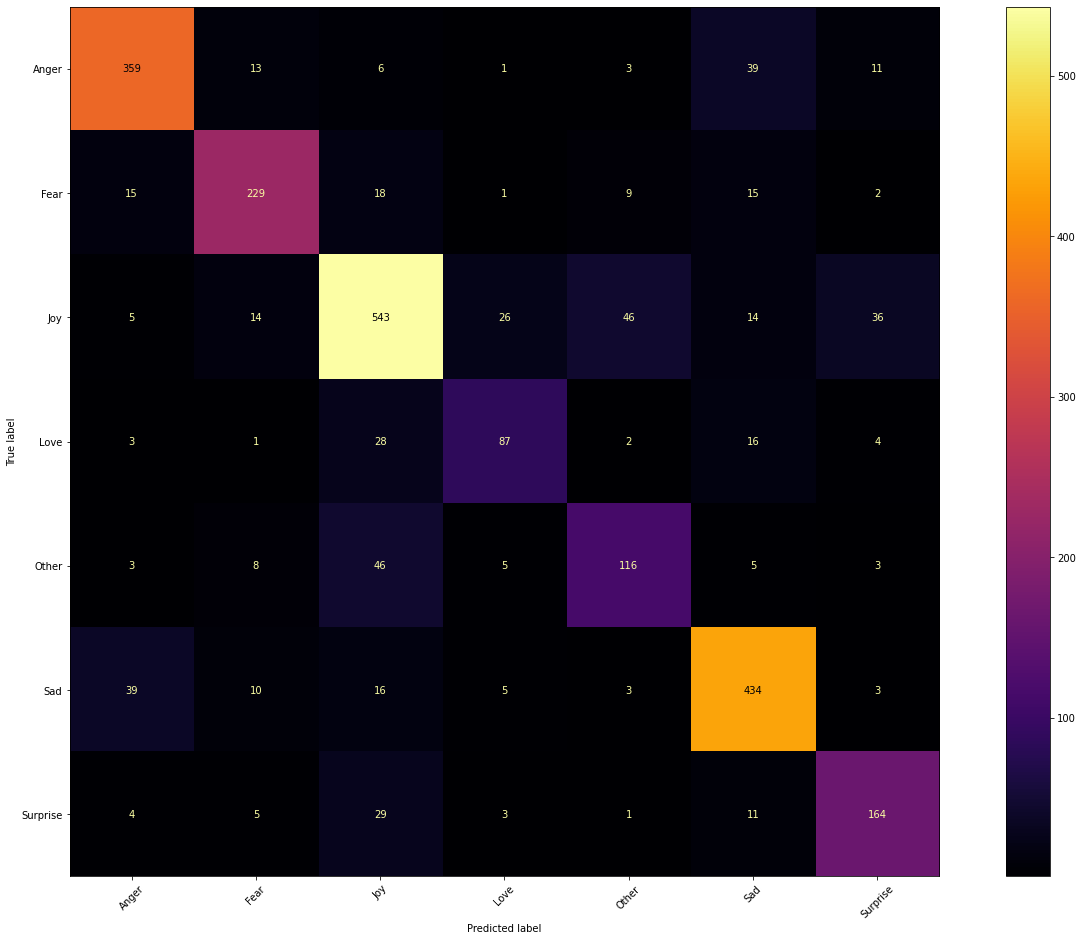

In [27]:
labs = BROAD_EMOTIONS.tolist()

yList = y.tolist()
yHatList = yHat.tolist()
truth = list(map(lambda x: labs[x], yList))
preds = list(map(lambda x: labs[x], yHatList))

fig, ax = plt.subplots(figsize=(24, 16))
ConfusionMatrixDisplay.from_predictions(truth, preds, labels=labs, xticks_rotation=45, cmap="inferno", ax=ax)
plt.show()

In [28]:
f1_score(truth, preds, average="micro")

0.7856852379015861

In [29]:
f1_list = f1_score(yList, yHatList, average=None)
f1_scores = dict()
for i, v in enumerate(f1_list):
  f1_scores[labs[i]] = v

print(json.dumps(f1_scores, indent=1))

{
 "Anger": 0.8348837209302324,
 "Fear": 0.804920913884007,
 "Joy": 0.7927007299270072,
 "Love": 0.6468401486988846,
 "Other": 0.6338797814207651,
 "Sad": 0.8314176245210727,
 "Surprise": 0.7454545454545455
}
